In [27]:
# https://github.com/indohito/EE399/tree/main/EE399HW6
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [29]:
num_sensors = 3 
lags = 52
gaussian_noise = 0
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sc = MinMaxScaler()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
def get_dataset(sc, device, load_X, num_sensors, lags, gaussian_noise):
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]
    
    ### create gaussian noise to add to data
    noise = np.random.normal(0, 1, (n, m)) * gaussian_noise
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X) + noise
    
    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]
        
    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    
    return train_dataset, valid_dataset, test_dataset


In [21]:
train_dataset, valid_dataset, test_dataset = get_dataset(sc, device, load_X, num_sensors, lags, gaussian_noise)

In [24]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.4760)
Training epoch 20
Error tensor(0.2202)
Training epoch 40
Error tensor(0.2163)
Training epoch 60
Error tensor(0.2139)
Training epoch 80
Error tensor(0.2153)
Training epoch 100
Error tensor(0.2141)


In [25]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))


0.035793632


In [30]:
num_sensors = 3 
lags_change = [11, 22, 33, 44, 52]
gaussian_noise = 0

In [31]:
lag_charting = []
for l in lags_change:
    train_dataset_lag, valid_dataset_lag, test_dataset_lag = get_dataset(sc, device, load_X, num_sensors, l, gaussian_noise)
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset_lag, valid_dataset_lag, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse_lag = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    lag_charting.append(mse_lag)
    

Training epoch 1
Error tensor(0.4697)
Training epoch 20
Error tensor(0.2390)
Training epoch 40
Error tensor(0.2257)
Training epoch 60
Error tensor(0.2185)
Training epoch 80
Error tensor(0.2148)
Training epoch 100
Error tensor(0.2093)
Training epoch 1
Error tensor(0.4747)
Training epoch 20
Error tensor(0.2445)
Training epoch 40
Error tensor(0.2206)
Training epoch 60
Error tensor(0.2219)
Training epoch 80
Error tensor(0.2163)
Training epoch 100
Error tensor(0.2084)
Training epoch 1
Error tensor(0.4727)
Training epoch 20
Error tensor(0.2221)
Training epoch 40
Error tensor(0.2146)
Training epoch 60
Error tensor(0.2108)
Training epoch 80
Error tensor(0.2052)
Training epoch 100
Error tensor(0.1979)
Training epoch 1
Error tensor(0.4799)
Training epoch 20
Error tensor(0.2227)
Training epoch 40
Error tensor(0.2148)
Training epoch 60
Error tensor(0.2132)
Training epoch 80
Error tensor(0.2098)
Training epoch 100
Error tensor(0.2029)
Training epoch 1
Error tensor(0.4908)
Training epoch 20
Error te

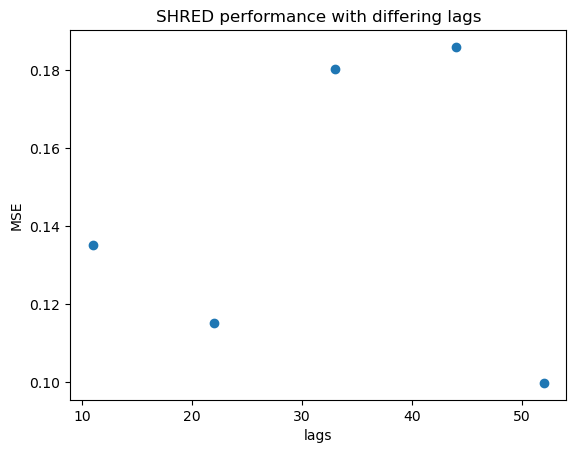

In [34]:
plt.figure()
plt.title("SHRED performance with differing lags")
plt.xlabel("lags")
plt.ylabel("MSE")
plt.scatter(lags_change, lag_charting)

In [35]:
num_sensors = 3
lags = 52
gaussian_noise = [0, .26, .55, .77, 1]

In [37]:
gause_charting = []
for g in gaussian_noise:
    train_dataset_gause, valid_dataset_gause, test_dataset_gause = get_dataset(sc, device, load_X, num_sensors, lags, g)
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset_gause, valid_dataset_gause, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)
    test_recons = sc.inverse_transform(shred(test_dataset_gause.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset_gause.Y.detach().cpu().numpy())
    mse_lag = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    gause_charting.append(mse_lag)
    print(" ")

Training epoch 1
Error tensor(0.4674)
Training epoch 20
Error tensor(0.2230)
Training epoch 40
Error tensor(0.2181)
Training epoch 60
Error tensor(0.2155)
Training epoch 80
Error tensor(0.2126)
Training epoch 100
Error tensor(0.2069)
 
Training epoch 1
Error tensor(0.6374)
Training epoch 20
Error tensor(0.5235)
Training epoch 40
Error tensor(0.5231)
Training epoch 60
Error tensor(0.5221)
Training epoch 80
Error tensor(0.5216)
Training epoch 100
Error tensor(0.5201)
 
Training epoch 1
Error tensor(0.8186)
Training epoch 20
Error tensor(0.7777)
Training epoch 40
Error tensor(0.7770)
Training epoch 60
Error tensor(0.7769)
Training epoch 80
Error tensor(0.7782)
Training epoch 100
Error tensor(0.7813)
 
Training epoch 1
Error tensor(0.8877)
Training epoch 20
Error tensor(0.8642)
Training epoch 40
Error tensor(0.8648)
Training epoch 60
Error tensor(0.8674)
Training epoch 80
Error tensor(0.8720)
Training epoch 100
Error tensor(0.8840)
 
Training epoch 1
Error tensor(0.9276)
Training epoch 20


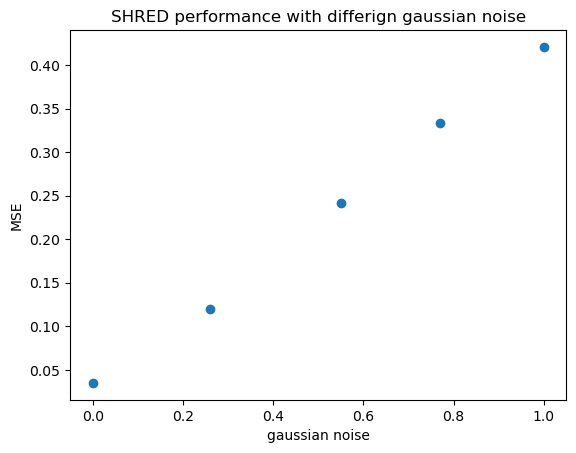

In [40]:
plt.figure()
plt.title("SHRED performance with differign gaussian noise")
plt.xlabel("gaussian noise")
plt.ylabel("MSE")
plt.scatter(gaussian_noise, gause_charting)

In [58]:
num_sensors_change = [3, 4, 5, 6, 7]
lags = 52
gaussian_noise = 0

In [60]:
sensor_charting = []
for s in num_sensors_change:
    train_dataset_sen, valid_dataset_sen, test_dataset_sen = get_dataset(sc, device, load_X, s, lags, gaussian_noise)
    shred = models.SHRED(s, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset_sen, valid_dataset_sen, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)
    test_recons = sc.inverse_transform(shred(test_dataset_sen.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset_sen.Y.detach().cpu().numpy())
    mse_lag = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    sensor_charting.append(mse_lag)
    print(" ")

Training epoch 1
Error tensor(0.4926)
Training epoch 20
Error tensor(0.2299)
Training epoch 40
Error tensor(0.2238)
Training epoch 60
Error tensor(0.2223)
Training epoch 80
Error tensor(0.2215)
Training epoch 100
Error tensor(0.2187)
 
Training epoch 1
Error tensor(0.4762)
Training epoch 20
Error tensor(0.2227)
Training epoch 40
Error tensor(0.2168)
Training epoch 60
Error tensor(0.2162)
Training epoch 80
Error tensor(0.2163)
Training epoch 100
Error tensor(0.2162)
 
Training epoch 1
Error tensor(0.4764)
Training epoch 20
Error tensor(0.2200)
Training epoch 40
Error tensor(0.2168)
Training epoch 60
Error tensor(0.2085)
Training epoch 80
Error tensor(0.2052)
Training epoch 100
Error tensor(0.1965)
 
Training epoch 1
Error tensor(0.4733)
Training epoch 20
Error tensor(0.2209)
Training epoch 40
Error tensor(0.2037)
Training epoch 60
Error tensor(0.1950)
Training epoch 80
Error tensor(0.1798)
Training epoch 100
Error tensor(0.1701)
 
Training epoch 1
Error tensor(0.4702)
Training epoch 20


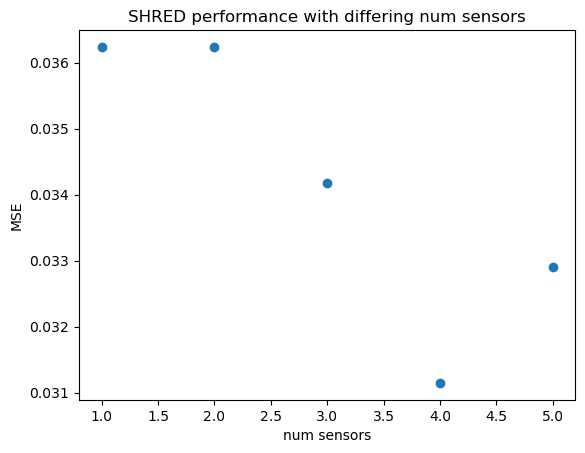

In [62]:
plt.figure()
plt.title("SHRED performance with differing num sensors")
plt.xlabel("num sensors")
plt.ylabel("MSE")
plt.scatter(num_sensors, sensor_charting)